# GANs Clássicas com BreastMNIST

Este notebook demonstra como treinar três variantes de GANs utilizando o dataset **MedMNIST**: **DCGAN**, **Conditional GAN** (CGAN) e **Wasserstein GAN com Gradiente Penalty** (WGAN-GP). O objetivo é gerar imagens sintéticas similares às do conjunto de dados.

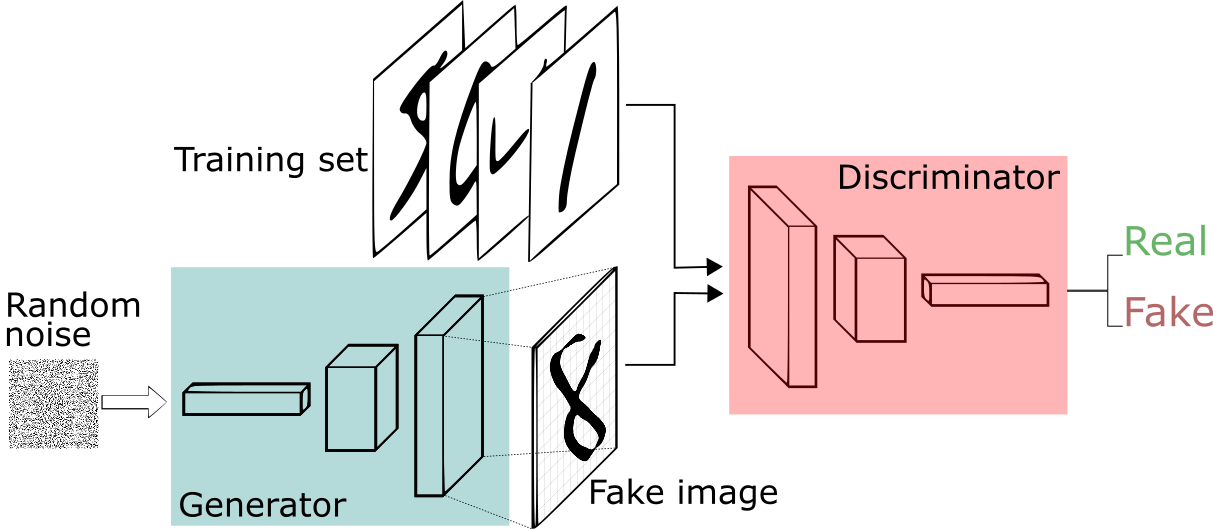!

## 1. Setup e Importações
Instale as dependências necessárias e carregue as principais bibliotecas utilizadas ao longo do notebook.

In [1]:
!pip install torch torchvision medmnist matplotlib torchmetrics seaborn scikit-learn scipy --quiet
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Carregamento e Preparação do Dataset

In [2]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

# Transformações básicas: conversão para tensor e normalização
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform, download=download)
test_dataset = getattr(medmnist, info['python_class'])(split='test', transform=transform, download=download)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [3]:
train_dataset

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/mahlow/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


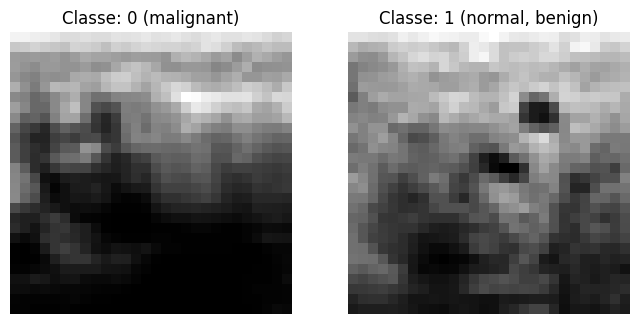

In [4]:
import matplotlib.pyplot as plt
from medmnist import INFO
import medmnist
from torchvision import transforms
from torch.utils.data import DataLoader
import random

# Configurações do dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

# Transformação
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Carrega dataset
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform, download=download)

# Número de classes
num_classes = len(info['label'])

# Agrupa índices por classe
class_indices = {i: [] for i in range(num_classes)}

for idx, (img, target) in enumerate(train_dataset):
    label = int(target.item())
    class_indices[label].append(idx)

# Seleciona um índice aleatório por classe
random_indices = {label: random.choice(indices) for label, indices in class_indices.items()}

# Plot
plt.figure(figsize=(8, 4))
for idx, (label, sample_idx) in enumerate(random_indices.items()):
    img, _ = train_dataset[sample_idx]
    img_disp = img * 0.5 + 0.5  # Desfaz normalização
    img_disp = img_disp.squeeze()
    plt.subplot(1, num_classes, idx + 1)
    plt.imshow(img_disp, cmap='gray')
    plt.title(f'Classe: {label} ({info["label"][str(label)]})')
    plt.axis('off')

plt.show()


In [5]:
from collections import Counter

# Conta as classes no train_dataset
train_labels = [int(label.item()) for _, label in train_dataset]
train_class_counts = Counter(train_labels)

# Conta as classes no test_dataset
test_labels = [int(label.item()) for _, label in test_dataset]
test_class_counts = Counter(test_labels)

# Exibe resultado para o train_dataset
print("Distribuição no conjunto de treino:")
for cls, count in sorted(train_class_counts.items()):
    nome = train_dataset.info['label'][str(cls)]
    print(f"Classe {cls} ({nome}): {count} amostras")

print("\nDistribuição no conjunto de teste:")
# Exibe resultado para o test_dataset
for cls, count in sorted(test_class_counts.items()):
    nome = test_dataset.info['label'][str(cls)]
    print(f"Classe {cls} ({nome}): {count} amostras")


Distribuição no conjunto de treino:
Classe 0 (malignant): 147 amostras
Classe 1 (normal, benign): 399 amostras

Distribuição no conjunto de teste:
Classe 0 (malignant): 42 amostras
Classe 1 (normal, benign): 114 amostras


## 3. Implementações das GANs
A seguir estão as implementações dos três modelos de GAN.

### DCGAN

## DCGAN (Deep Convolutional Generative Adversarial Network)

- É um tipo de Generative Adversarial Network (GAN) que utiliza redes convolucionais profundas.
- O gerador usa camadas convolucionais transpostas para criar imagens a partir de vetores de ruído.
- O discriminador é uma rede convolucional que distingue imagens reais de imagens geradas.
- Substitui camadas de pooling por camadas convolucionais com stride para melhor aprendizado espacial.

In [12]:
import torch
import torch.nn as nn


class DCGenerator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),  # (7x7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # (14x14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),  # (28x28)
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class DCDiscriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),  # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),          # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## 4. Loop de Treinamento
Modelo simplificado para treinar cada uma das GANs. Ajuste hiperparâmetros conforme necessário.

In [7]:
def train_gan_for_class(train_loader, label_target, G, D, latent_dim=100, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    G.train()
    D.train()

    for epoch in range(num_epochs):
        epoch_loss_D = 0
        epoch_loss_G = 0
        batches_processed = 0

        for imgs, labels in train_loader:
            # Filtra apenas as imagens da classe desejada
            mask = (labels.squeeze() == label_target)
            if mask.sum() == 0:
                continue  # Nenhuma amostra dessa classe no batch

            real = imgs[mask].to(device)
            b_size = real.size(0)
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)

            # --- Discriminador ---
            optim_D.zero_grad()
            fake = G(noise)
            loss_real = criterion(D(real), torch.ones(b_size, 1, device=device))
            loss_fake = criterion(D(fake.detach()), torch.zeros(b_size, 1, device=device))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optim_D.step()

            # --- Gerador ---
            optim_G.zero_grad()
            output = D(fake)
            loss_G = criterion(output, torch.ones(b_size, 1, device=device))
            loss_G.backward()
            optim_G.step()

            epoch_loss_D += loss_D.item()
            epoch_loss_G += loss_G.item()
            batches_processed += 1

        if batches_processed > 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss D: {epoch_loss_D/batches_processed:.3f} | Loss G: {epoch_loss_G/batches_processed:.3f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Nenhum batch da classe {label_target} processado.")

    return G


In [157]:
latent_dim = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = DCGenerator(latent_dim=latent_dim).to(device)
D = DCDiscriminator(img_channels=1).to(device)


G_mal = DCGenerator(latent_dim=latent_dim).to(device)
D_mal = DCDiscriminator(img_channels=1).to(device)
malignant_G = train_gan_for_class(train_loader, label_target=0, G=G_mal, D=D_mal, latent_dim=latent_dim, num_epochs=50, device=device)

G_ben = DCGenerator(latent_dim=latent_dim).to(device)
D_ben = DCDiscriminator(img_channels=1).to(device)
benign_G = train_gan_for_class(train_loader, label_target=1, G=G_ben, D=D_ben, latent_dim=latent_dim, num_epochs=50, device=device)

Epoch 1/50 - Loss D: 0.901 | Loss G: 1.181
Epoch 2/50 - Loss D: 0.467 | Loss G: 1.832
Epoch 3/50 - Loss D: 0.375 | Loss G: 1.991
Epoch 4/50 - Loss D: 0.254 | Loss G: 2.527
Epoch 5/50 - Loss D: 0.227 | Loss G: 2.635
Epoch 6/50 - Loss D: 0.210 | Loss G: 2.616
Epoch 7/50 - Loss D: 0.179 | Loss G: 2.803
Epoch 8/50 - Loss D: 0.181 | Loss G: 2.851
Epoch 9/50 - Loss D: 0.181 | Loss G: 2.898
Epoch 10/50 - Loss D: 0.190 | Loss G: 2.914
Epoch 11/50 - Loss D: 0.207 | Loss G: 3.008
Epoch 12/50 - Loss D: 0.249 | Loss G: 3.001
Epoch 13/50 - Loss D: 0.236 | Loss G: 3.106
Epoch 14/50 - Loss D: 0.520 | Loss G: 2.811
Epoch 15/50 - Loss D: 0.305 | Loss G: 2.710
Epoch 16/50 - Loss D: 0.420 | Loss G: 2.547
Epoch 17/50 - Loss D: 0.715 | Loss G: 2.475
Epoch 18/50 - Loss D: 0.465 | Loss G: 2.289
Epoch 19/50 - Loss D: 0.386 | Loss G: 2.269
Epoch 20/50 - Loss D: 0.638 | Loss G: 2.125
Epoch 21/50 - Loss D: 0.830 | Loss G: 2.077
Epoch 22/50 - Loss D: 0.556 | Loss G: 1.720
Epoch 23/50 - Loss D: 0.790 | Loss G: 1.9

In [8]:
import matplotlib.pyplot as plt
import torch
import random

def compare_generated_real_grid(malignant_G, benign_G, latent_dim, device, dataset, num_samples=3):
    malignant_G.eval()
    benign_G.eval()

    # Gera amostras sintéticas
    noise_mal = torch.randn(num_samples, latent_dim, 1, 1, device=device)
    noise_ben = torch.randn(num_samples, latent_dim, 1, 1, device=device)

    with torch.no_grad():
        fake_mal = malignant_G(noise_mal).cpu()
        fake_ben = benign_G(noise_ben).cpu()

    # Coleta todos os reais disponíveis em listas
    real_mal_all = [img for img, label in dataset if int(label.item()) == 0]
    real_ben_all = [img for img, label in dataset if int(label.item()) == 1]

    # Escolhe amostras aleatórias
    real_mal = random.sample(real_mal_all, num_samples)
    real_ben = random.sample(real_ben_all, num_samples)

    # Plot com bordas simuladas
    fig, axes = plt.subplots(nrows=num_samples, ncols=4, figsize=(12, 3 * num_samples))

    for i in range(num_samples):
        imgs = [
            fake_mal[i].squeeze() * 0.5 + 0.5,
            real_mal[i].squeeze() * 0.5 + 0.5,
            fake_ben[i].squeeze() * 0.5 + 0.5,
            real_ben[i].squeeze() * 0.5 + 0.5
        ]
        titles = ["Gerada Malignant", "Real Malignant", "Gerada Benign", "Real Benign"]

        for j in range(4):
            ax = axes[i, j]
            ax.imshow(imgs[j], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            for side in ['top', 'bottom', 'left', 'right']:
                ax.spines[side].set_visible(True)
                ax.spines[side].set_linewidth(1)
            if i == 0:
                ax.set_title(titles[j], fontsize=10)

    plt.tight_layout()
    plt.show()


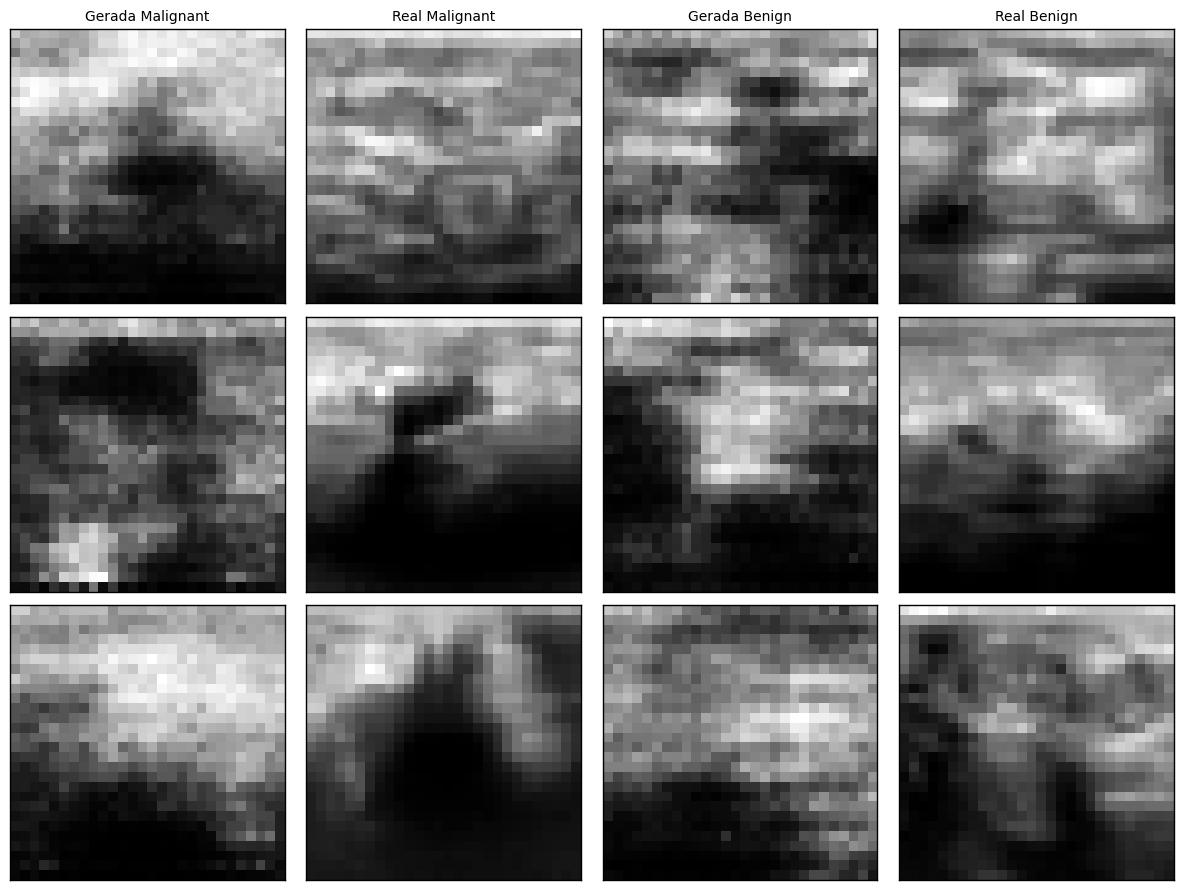

In [203]:
compare_generated_real_grid( 
    malignant_G=G_mal,
    benign_G=G_ben,
    latent_dim=latent_dim,
    device=device,
    dataset=train_dataset
)

## 5. Avaliação com Métricas
Avaliamos as imagens geradas utilizando as métricas **FID** e **Inception Score**, disponíveis no pacote `torchmetrics`.

### Frechet Inception Distance (FID)


$\mathrm{FID} = \|\mu_r - \mu_g\|^2 + \operatorname{Tr}\left( \Sigma_r + \Sigma_g - 2 \left( \Sigma_r \Sigma_g \right)^{1/2} \right)$


onde:
- $\mu_r$ = média das features reais
- $\mu_g$ = média das features geradas
- $\Sigma_r$ = covariância das features reais
- $\Sigma_g$ = covariância das features geradas

---

### Inception Score (IS)

$ \mathrm{IS} = \exp \left( \mathbb{E}_x \left[ D_{\mathrm{KL}}\left( p(y|x) \;||\; p(y) \right) \right] \right) $

onde:
- $p(y|x)$ = distribuição predita para a imagem gerada
- $p(y)$ = distribuição marginal $p(y) = \int p(y|x) p(x) dx$
- $\mathbb{E}_x$: valor esperado sobre as imagens geradas (média)
- $D_{\mathrm{KL}}$: divergência de Kullback-Leibler


In [204]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch.nn.functional as F
import pandas as pd

def evaluate_gan(G, latent_dim, device, dataset, label_target, gan_name, gen_label_name, batch_size=64, max_batches=10):
    fid = FrechetInceptionDistance(feature=64).to(device)
    is_metric = InceptionScore().to(device)

    G.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        batch_count = 0
        for real, labels in loader:
            mask = (labels.squeeze() == label_target)
            if mask.sum() == 0:
                continue
            real = real[mask].to(device)

            b_size = real.size(0)
            if b_size == 0:
                continue

            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)

            # Checa se o gerador é CGAN
            if gan_name == 'CGAN':
                gen_labels = torch.full((b_size,), label_target, device=device, dtype=torch.long)
                fake = G(noise, gen_labels)
            else:
                fake = G(noise)

            # Escala para [0, 255]
            real_uint8 = ((real * 0.5 + 0.5) * 255).clamp(0, 255).to(torch.uint8)
            fake_uint8 = ((fake * 0.5 + 0.5) * 255).clamp(0, 255).to(torch.uint8)

            # Corrige para 3 canais
            real_uint8 = real_uint8.repeat(1, 3, 1, 1)
            fake_uint8 = fake_uint8.repeat(1, 3, 1, 1)

            fid.update(real_uint8, real=True)
            fid.update(fake_uint8, real=False)
            is_metric.update(fake_uint8)

            batch_count += 1
            if batch_count >= max_batches:
                break

    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
    is_mean = is_mean.item()
    is_std = is_std.item()

    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name.capitalize(),
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean,
        'IS_Std': is_std
    }


results = []

# Malignant G -> real Malignant
res = evaluate_gan(G_mal, latent_dim, device, train_dataset, 0, 'DCGAN', 'malignant')
results.append(res)

# Malignant G -> real Benign (cruzado)
res = evaluate_gan(G_mal, latent_dim, device, train_dataset, 1, 'DCGAN', 'malignant')
results.append(res)

# Benign G -> real Benign
res = evaluate_gan(G_ben, latent_dim, device, train_dataset, 1, 'DCGAN', 'benign')
results.append(res)

# Benign G -> real Malignant (cruzado)
res = evaluate_gan(G_ben, latent_dim, device, train_dataset, 0, 'DCGAN', 'benign')
results.append(res)

# DataFrame
df_results = pd.DataFrame(results)
df_results

/home/mahlow/anaconda3/envs/my_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


,GAN,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,DCGAN,Malignant,Malignant,0.230097,1.610454,0.121275
1,DCGAN,Malignant,Benign,0.503274,1.749113,0.085871
2,DCGAN,Benign,Benign,0.108178,1.670056,0.055528
3,DCGAN,Benign,Malignant,0.161613,1.677272,0.150974


## 6. Comparando Modelos

### Conditional GAN

- É uma extensão da GAN que permite condicionar a geração de amostras a informações adicionais (por exemplo, rótulos de classe).
- Tanto o gerador quanto o discriminador recebem como entrada a variável de condição (ex.: o rótulo da classe).
- O gerador cria imagens que buscam corresponder à condição fornecida.
- O discriminador avalia se a imagem é real ou falsa levando em conta essa condição.
- Permite maior controle sobre o tipo de dado gerado, tornando possível direcionar a geração para classes específicas.

In [205]:
import torch.nn as nn

class CGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2, img_channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Projeção do noise + label para o início da rede
        self.init_size = 7  # Para 28x28, ajuste conforme sua resolução
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise.squeeze(), label_input), -1)  # Remove dimensões extras do noise
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class CGANDiscriminator(nn.Module):
    def __init__(self, num_classes=9, img_channels=3):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Pool para garantir tamanho fixo
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 1)

    def forward(self, img, labels):
        label_img = self.label_emb(labels).unsqueeze(2).unsqueeze(3).expand(-1, -1, img.size(2), img.size(3))
        x = torch.cat([img, label_img], 1)
        x = self.conv(x)
        x = self.adaptive_pool(x)  # output fixo: (batch, 128, 4, 4)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x




def train_cgan(train_loader, G, D, latent_dim, num_classes, num_epochs, device, label_target):
    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    G.train()
    D.train()

    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            # Filtra a classe desejada
            mask = (labels.squeeze() == label_target)
            if mask.sum() == 0:
                continue
            real = imgs[mask].to(device)
            labels_real = labels[mask].squeeze().long().to(device)
            b_size = real.size(0)

            # Gera rótulos e noise
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            gen_labels = torch.full((b_size,), label_target, device=device, dtype=torch.long)

            # Discriminator
            optim_D.zero_grad()
            fake = G(noise, gen_labels)
            loss_real = criterion(D(real, labels_real), torch.ones(b_size, 1, device=device))
            loss_fake = criterion(D(fake.detach(), gen_labels), torch.zeros(b_size, 1, device=device))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optim_D.step()

            # Generator
            optim_G.zero_grad()
            output = D(fake, gen_labels)
            loss_G = criterion(output, torch.ones(b_size, 1, device=device))
            loss_G.backward()
            optim_G.step()

    return G

### WGAN-GP

## Wasserstein GAN com Gradiente Penalty (WGAN-GP)

- É uma variante dos GANs que usa a distância de Wasserstein como métrica de diferença entre as distribuições real e gerada.
- Substitui o discriminador tradicional por um "critic", que não usa função sigmoide na saída e retorna um valor escalar para medir a qualidade das amostras.

In [206]:
import torch
import torch.nn as nn

class WGANGPGenerator(DCGenerator):
    def __init__(self, latent_dim=100, img_channels=1):
        super().__init__(latent_dim=latent_dim, img_channels=img_channels)

# ===== Critic =====
class WGANGPCritic(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# ===== Gradient Penalty =====
def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real.device)
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)
    grad_outputs = torch.ones_like(mixed_scores)

    gradients = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# ===== Treino =====
def train_wgangp(train_loader, G, D, latent_dim, num_epochs, device, label_target=None, critic_iters=5, lambda_gp=10):
    optim_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optim_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

    G.train()
    D.train()

    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            if label_target is not None:
                mask = (labels.squeeze() == label_target)
                if mask.sum() == 0:
                    continue
                real = imgs[mask].to(device)
            else:
                real = imgs.to(device)

            b_size = real.size(0)
            if b_size == 0:
                continue

            # Critic steps
            for _ in range(critic_iters):
                noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
                fake = G(noise)

                D_real = D(real).view(-1)
                D_fake = D(fake.detach()).view(-1)

                gp = gradient_penalty(D, real, fake)
                loss_D = -(D_real.mean() - D_fake.mean()) + lambda_gp * gp

                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()

            # Generator step
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            fake = G(noise)
            loss_G = -D(fake).view(-1).mean()

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    return G

In [20]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import pandas as pd
import torch.nn.functional as F

# ========== Configurações ==========
latent_dim = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 50
num_classes = 2  # Malignant=0, Benign=1

# ========== Treinamento e armazenamento dos geradores ==========
G_dc_dict = {}
G_cg_dict = {}
G_wg_dict = {}

# DCGAN
for label_target, label_name in zip([0, 1], ['malignant', 'benign']):
    G_dc = DCGenerator(latent_dim=latent_dim).to(device)
    D_dc = DCDiscriminator(img_channels=1).to(device)
    G_dc_trained = train_gan_for_class(
        train_loader=train_loader,
        label_target=label_target,
        G=G_dc,
        D=D_dc,
        latent_dim=latent_dim,
        num_epochs=num_epochs,
        device=device
    )
    G_dc_dict[label_name] = G_dc_trained

# CGAN
for label_target, label_name in zip([0, 1], ['malignant', 'benign']):
    G_cg = CGANGenerator(latent_dim=latent_dim, num_classes=num_classes, img_channels=1).to(device)
    D_cg = CGANDiscriminator(num_classes=num_classes, img_channels=1).to(device)
    G_cg_trained = train_cgan(
        train_loader=train_loader,
        G=G_cg,
        D=D_cg,
        latent_dim=latent_dim,
        num_classes=num_classes,
        num_epochs=num_epochs,
        device=device,
        label_target=label_target
    )
    G_cg_dict[label_name] = G_cg_trained

# WGAN-GP
for label_target, label_name in zip([0, 1], ['malignant', 'benign']):
    G_wg = WGANGPGenerator(latent_dim=latent_dim, img_channels=1).to(device)
    D_wg = WGANGPCritic(img_channels=1).to(device)
    G_wg_trained = train_wgangp(
        train_loader=train_loader,
        G=G_wg,
        D=D_wg,
        latent_dim=latent_dim,
        num_epochs=num_epochs,
        device=device,
        label_target=label_target
    )
    G_wg_dict[label_name] = G_wg_trained

Epoch 1/50 - Loss D: 1.007 | Loss G: 1.121
Epoch 2/50 - Loss D: 0.455 | Loss G: 1.804
Epoch 3/50 - Loss D: 0.326 | Loss G: 2.240
Epoch 4/50 - Loss D: 0.265 | Loss G: 2.449
Epoch 5/50 - Loss D: 0.196 | Loss G: 3.056
Epoch 6/50 - Loss D: 0.110 | Loss G: 3.209
Epoch 7/50 - Loss D: 0.086 | Loss G: 3.558
Epoch 8/50 - Loss D: 0.141 | Loss G: 3.215
Epoch 9/50 - Loss D: 0.170 | Loss G: 3.059
Epoch 10/50 - Loss D: 0.226 | Loss G: 3.128
Epoch 11/50 - Loss D: 0.106 | Loss G: 3.689
Epoch 12/50 - Loss D: 0.081 | Loss G: 3.857
Epoch 13/50 - Loss D: 0.057 | Loss G: 4.092
Epoch 14/50 - Loss D: 0.109 | Loss G: 3.687
Epoch 15/50 - Loss D: 0.172 | Loss G: 3.228
Epoch 16/50 - Loss D: 0.330 | Loss G: 2.917
Epoch 17/50 - Loss D: 0.348 | Loss G: 2.985
Epoch 18/50 - Loss D: 0.259 | Loss G: 2.668
Epoch 19/50 - Loss D: 1.116 | Loss G: 2.585
Epoch 20/50 - Loss D: 0.540 | Loss G: 2.111
Epoch 21/50 - Loss D: 0.383 | Loss G: 2.300
Epoch 22/50 - Loss D: 0.394 | Loss G: 2.211
Epoch 23/50 - Loss D: 0.362 | Loss G: 2.2

NameError: name 'CGANGenerator' is not defined

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

def evaluate_gan(
    G,
    latent_dim,
    device,
    dataset,
    label_target,
    gan_name,
    gen_label_name,
    max_batches: float = float('inf'),
    batch_size: int = 64
):
   
    fid = FrechetInceptionDistance(feature=64).to(device)
    is_metric = InceptionScore().to(device)

    G.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    batch_count = 0
    with torch.no_grad():
        for real, labels in loader:
            # filtra só a classe desejada
            mask = (labels.squeeze() == label_target)
            if mask.sum() == 0:
                continue

            real = real[mask].to(device)
            b_size = real.size(0)
            if b_size == 0:
                continue

            # amostra ruído e gera
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            if gan_name == 'CGAN':
                gen_labels = torch.full((b_size,), label_target, device=device)
                fake = G(noise, gen_labels)
            else:
                fake = G(noise)

            # converte para uint8 3-canais [0..255]
            real_uint8 = ((real * 0.5 + 0.5) * 255).clamp(0, 255).to(torch.uint8)
            fake_uint8 = ((fake * 0.5 + 0.5) * 255).clamp(0, 255).to(torch.uint8)
            real_uint8 = real_uint8.repeat(1, 3, 1, 1)
            fake_uint8 = fake_uint8.repeat(1, 3, 1, 1)

            # atualiza métricas
            fid.update(real_uint8, real=True)
            fid.update(fake_uint8, real=False)
            is_metric.update(fake_uint8)

            batch_count += 1
            if batch_count >= max_batches:
                break

    # 2) Após processar todos os batches, calcula scores finais
    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
    is_mean = is_mean.item()
    is_std = is_std.item()

    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name.capitalize(),
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean,
        'IS_Std': is_std
    }


# ========== Avaliação ==========
results = []

# Lista dos geradores e os targets corretos
generators = [
    {'gan': 'DCGAN', 'gen_label': 'malignant', 'G': G_dc_dict['malignant'], 'target': 0},
    {'gan': 'DCGAN', 'gen_label': 'benign', 'G': G_dc_dict['benign'], 'target': 1},
    {'gan': 'CGAN', 'gen_label': 'malignant', 'G': G_cg_dict['malignant'], 'target': 0},
    {'gan': 'CGAN', 'gen_label': 'benign', 'G': G_cg_dict['benign'], 'target': 1},
    {'gan': 'WGAN-GP', 'gen_label': 'malignant', 'G': G_wg_dict['malignant'], 'target': 0},
    {'gan': 'WGAN-GP', 'gen_label': 'benign', 'G': G_wg_dict['benign'], 'target': 1},
]

# Avalia apenas o par gerador / real da mesma classe
for item in generators:
    res = evaluate_gan(
        G=item['G'],
        latent_dim=latent_dim,
        device=device,
        dataset=train_dataset,
        label_target=item['target'],  # apenas o target correto
        gan_name=item['gan'],
        gen_label_name=item['gen_label']
    )
    results.append(res)

# ========== DataFrame final ==========
df_results = pd.DataFrame(results)
df_results


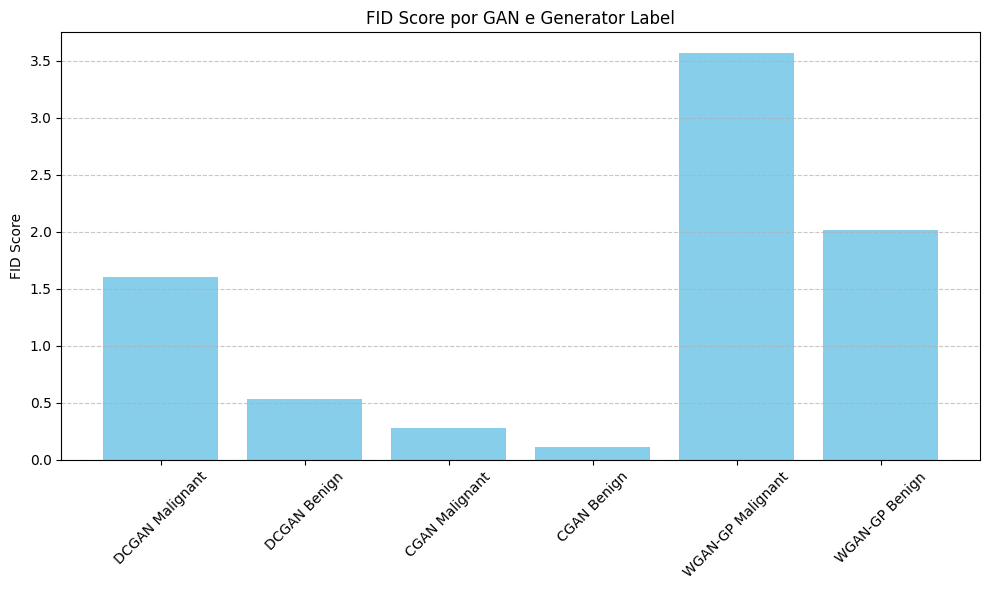

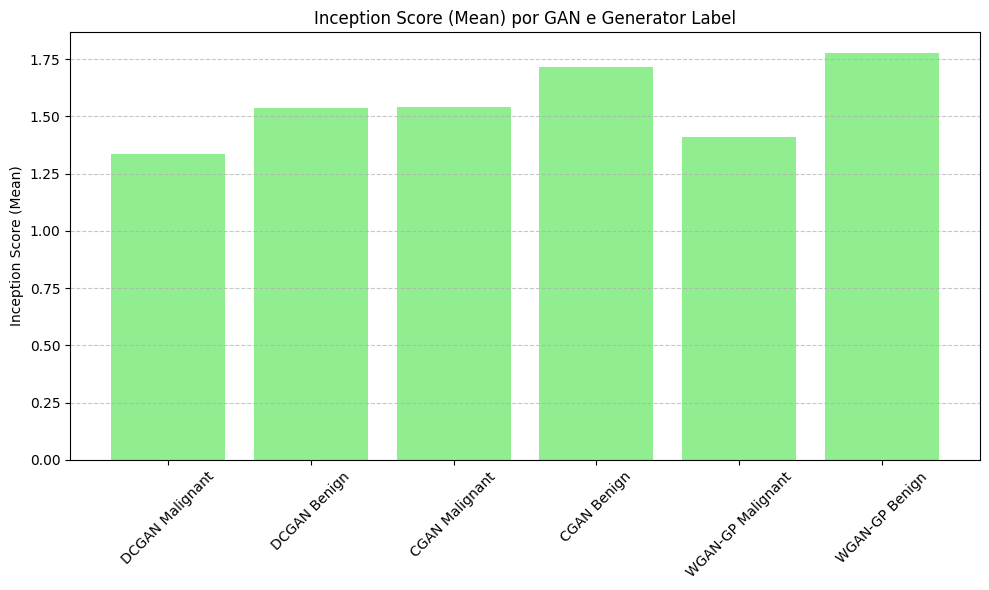

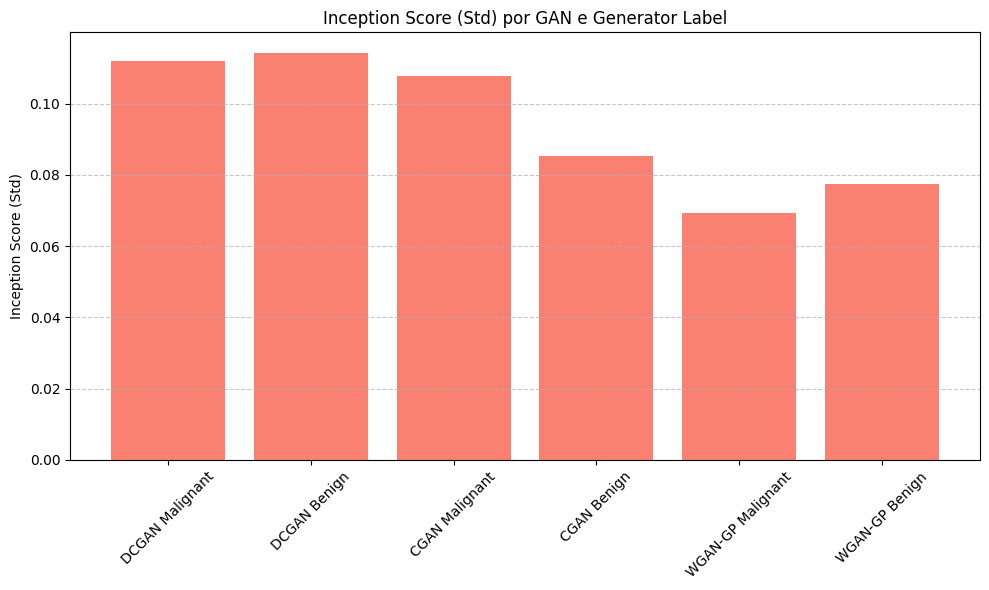

In [209]:
import matplotlib.pyplot as plt
import pandas as pd

# Tabela de resultados
data = {
    'GAN': ['DCGAN', 'DCGAN', 'CGAN', 'CGAN', 'WGAN-GP', 'WGAN-GP'],
    'Generator_Label': ['Malignant', 'Benign', 'Malignant', 'Benign', 'Malignant', 'Benign'],
    'Real_Label': ['Malignant', 'Benign', 'Malignant', 'Benign', 'Malignant', 'Benign'],
    'FID': [1.604931, 0.534997, 0.275888, 0.117014, 3.572813, 2.015038],
    'IS_Mean': [1.337436, 1.534522, 1.541860, 1.715486, 1.410435, 1.777562],
    'IS_Std': [0.111827, 0.114257, 0.107841, 0.085154, 0.069321, 0.077350]
}
df = pd.DataFrame(data)

# Cria um identificador de eixo X
df['Label'] = df['GAN'] + ' ' + df['Generator_Label']

# Gráfico FID
plt.figure(figsize=(10, 6))
plt.bar(df['Label'], df['FID'], color='skyblue')
plt.ylabel('FID Score')
plt.title('FID Score por GAN e Generator Label')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico Inception Score (Mean)
plt.figure(figsize=(10, 6))
plt.bar(df['Label'], df['IS_Mean'], color='lightgreen')
plt.ylabel('Inception Score (Mean)')
plt.title('Inception Score (Mean) por GAN e Generator Label')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico Inception Score (Std)
plt.figure(figsize=(10, 6))
plt.bar(df['Label'], df['IS_Std'], color='salmon')
plt.ylabel('Inception Score (Std)')
plt.title('Inception Score (Std) por GAN e Generator Label')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Gráfico de Loss das GANs

In [9]:
def train_gan_for_class_with_loss(train_loader, label_target, G, D, latent_dim=100, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    G.train()
    D.train()

    hist_D, hist_G = [], []
    for epoch in range(num_epochs):
        epoch_loss_D = 0
        epoch_loss_G = 0
        batches = 0
        for imgs, labels in train_loader:
            mask = (labels.squeeze() == label_target)
            if mask.sum() == 0:
                continue
            real = imgs[mask].to(device)
            b_size = real.size(0)
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)

            optim_D.zero_grad()
            fake = G(noise)
            loss_real = criterion(D(real), torch.ones(b_size, 1, device=device))
            loss_fake = criterion(D(fake.detach()), torch.zeros(b_size, 1, device=device))
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optim_D.step()

            optim_G.zero_grad()
            output = D(fake)
            loss_G = criterion(output, torch.ones(b_size, 1, device=device))
            loss_G.backward()
            optim_G.step()

            epoch_loss_D += loss_D.item()
            epoch_loss_G += loss_G.item()
            batches += 1
        if batches > 0:
            hist_D.append(epoch_loss_D / batches)
            hist_G.append(epoch_loss_G / batches)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss D: {hist_D[-1]:.3f} | Loss G: {hist_G[-1]:.3f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Nenhum batch da classe {label_target} processado.")
    return G, hist_D, hist_G


Epoch 1/50 - Loss D: 0.992 | Loss G: 1.141
Epoch 2/50 - Loss D: 0.418 | Loss G: 1.933
Epoch 3/50 - Loss D: 0.229 | Loss G: 2.521
Epoch 4/50 - Loss D: 0.218 | Loss G: 2.543
Epoch 5/50 - Loss D: 0.192 | Loss G: 2.861
Epoch 6/50 - Loss D: 0.150 | Loss G: 3.102
Epoch 7/50 - Loss D: 0.094 | Loss G: 3.474
Epoch 8/50 - Loss D: 0.095 | Loss G: 3.548
Epoch 9/50 - Loss D: 0.075 | Loss G: 3.929
Epoch 10/50 - Loss D: 0.102 | Loss G: 3.771
Epoch 11/50 - Loss D: 0.075 | Loss G: 3.745
Epoch 12/50 - Loss D: 0.144 | Loss G: 3.523
Epoch 13/50 - Loss D: 0.136 | Loss G: 3.560
Epoch 14/50 - Loss D: 0.175 | Loss G: 3.707
Epoch 15/50 - Loss D: 0.173 | Loss G: 3.483
Epoch 16/50 - Loss D: 0.213 | Loss G: 3.369
Epoch 17/50 - Loss D: 0.225 | Loss G: 3.490
Epoch 18/50 - Loss D: 0.138 | Loss G: 3.663
Epoch 19/50 - Loss D: 0.177 | Loss G: 3.141
Epoch 20/50 - Loss D: 0.829 | Loss G: 3.213
Epoch 21/50 - Loss D: 0.536 | Loss G: 2.379
Epoch 22/50 - Loss D: 0.348 | Loss G: 2.568
Epoch 23/50 - Loss D: 0.306 | Loss G: 2.5

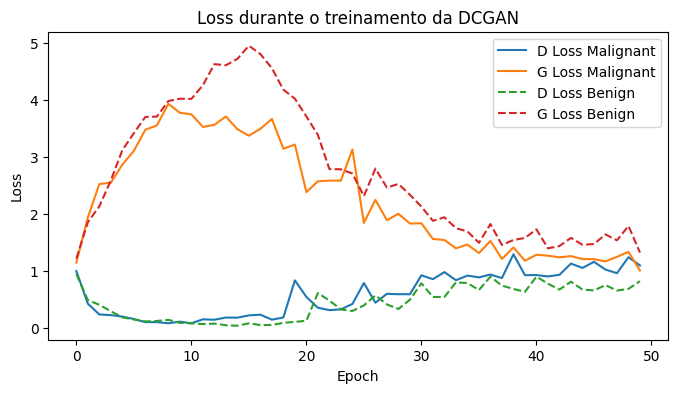

In [14]:
# Exemplo de treinamento registrando as losses
device='cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 100
num_epochs = 50
losses_dc = {}
G_mal = DCGenerator(latent_dim=latent_dim).to(device)
D_mal = DCDiscriminator(img_channels=1).to(device)
malignant_G, loss_D_mal, loss_G_mal = train_gan_for_class_with_loss(train_loader, 0, G_mal, D_mal, latent_dim, num_epochs, device)

G_ben = DCGenerator(latent_dim=latent_dim).to(device)
D_ben = DCDiscriminator(img_channels=1).to(device)
benign_G, loss_D_ben, loss_G_ben = train_gan_for_class_with_loss(train_loader, 1, G_ben, D_ben, latent_dim, num_epochs, device)

plt.figure(figsize=(8,4))
plt.plot(loss_D_mal, label='D Loss Malignant')
plt.plot(loss_G_mal, label='G Loss Malignant')
plt.plot(loss_D_ben, label='D Loss Benign', linestyle='--')
plt.plot(loss_G_ben, label='G Loss Benign', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss durante o treinamento da DCGAN')
plt.show()


## Classificação com ResNet-18

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.models import resnet18
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# --- collate_fn e SyntheticDataset permanecem inalterados ---

def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ys_list = []
    for y in ys:
        if isinstance(y, torch.Tensor):
            val = y.item() if y.numel() == 1 else int(y.argmax().item())
        else:
            val = int(y)
        ys_list.append(val)
    ys = torch.tensor(ys_list, dtype=torch.long)
    return xs, ys

class SyntheticDataset(Dataset):
    def __init__(self, generator_dict, num_per_class, latent_dim, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        for label_name, gen in generator_dict.items():
            label = 0 if label_name == 'malignant' else 1
            noise = torch.randn(num_per_class, latent_dim, 1, 1, device=device)
            with torch.no_grad():
                imgs = gen(noise).cpu()
            for img in imgs:
                self.samples.append((img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# --- Função de treino inalterada ---

def train_model(model, loader, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

# --- NOVA evaluate que retorna tn, fp, fn, tp ---

def evaluate(model, loader, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(y)

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')

    # Confusion matrix: [[tn, fp], [fn, tp]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return acc, prec, rec, f1, auc, tn, fp, fn, tp

# --- run_experiments estendido com os dois casos extra ---

def run_experiments(train_dataset, test_dataset, G_dc_dict, latent_dim,
                    batch_size=32, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
    results = []

    # 1) Casos mistos real + sintético
    for r in ratios:
        if r == 0.0:
            ds = train_dataset
        else:
            num_syn = int(len(train_dataset) * r)
            syn_ds = SyntheticDataset(G_dc_dict, num_syn // 2, latent_dim, device)
            ds = ConcatDataset([train_dataset, syn_ds])

        loader = DataLoader(ds, batch_size=batch_size, shuffle=True,
                            collate_fn=custom_collate_fn)

        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)

        train_model(model, loader, epochs=epochs, device=device)

        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False,
                                 collate_fn=custom_collate_fn)

        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(
            model, test_loader, device=device
        )

        results.append({
            'ratio':          r,
            'acc':            acc,
            'prec':           prec,
            'rec':            rec,
            'f1':             f1,
            'auc':            auc,
            'tn':             tn,
            'fp':             fp,
            'fn':             fn,
            'tp':             tp
        })

    # 2) Treino 100% sintético, testado nos dados REAIS
    syn_only_ds = SyntheticDataset(G_dc_dict, len(train_dataset)//2,
                                   latent_dim, device)
    syn_loader  = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True,
                             collate_fn=custom_collate_fn)

    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(
        model, test_loader, device=device
    )
    results.append({
        'ratio': '100%_sintético→real',
        'acc':   acc,
        'prec':  prec,
        'rec':   rec,
        'f1':    f1,
        'auc':   auc,
        'tn':    tn,
        'fp':    fp,
        'fn':    fn,
        'tp':    tp
    })

    # 3) Treino 100% sintético (70% treino / 30% teste) e testado nele próprio
    total_syn = len(syn_only_ds)
    n_train   = int(total_syn * 0.7)
    n_test    = total_syn - n_train
    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])

    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=custom_collate_fn)
    test_loader  = DataLoader(syn_test_ds,  batch_size=batch_size, shuffle=False,
                              collate_fn=custom_collate_fn)

    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)

    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(
        model, test_loader, device=device
    )
    results.append({
        'ratio': '100%_sintético_70/30_selftest',
        'acc':   acc,
        'prec':  prec,
        'rec':   rec,
        'f1':    f1,
        'auc':   auc,
        'tn':    tn,
        'fp':    fp,
        'fn':    fn,
        'tp':    tp
    })

    return pd.DataFrame(results)

# Executa e exibe
results_df = run_experiments(train_dataset, test_dataset,
                             G_dc_dict, latent_dim,
                             batch_size=64, epochs=5)
results_df

/tmp/ipykernel_60392/4007068447.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60392/4007068447.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60392/4007068447.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60392/4007068447.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a singl

,ratio,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,0.0,0.807692,0.896226,0.833333,0.863636,0.785714,31,11,19,95
1,0.25,0.717949,0.906977,0.684211,0.780000,0.746867,34,8,36,78
2,0.5,0.865385,0.866142,0.964912,0.912863,0.780075,25,17,4,110
3,0.75,0.852564,0.876033,0.929825,0.902128,0.786341,27,15,8,106
4,1.0,0.833333,0.833333,0.964912,0.894309,0.720551,20,22,4,110
5,1.5,0.852564,0.869919,0.938596,0.902954,0.778822,26,16,7,107
6,100%_sintético→real,0.570513,0.885246,0.473684,0.617143,0.653509,35,7,60,54
7,100%_sintético_70/30_selftest,0.817073,1.000000,0.651163,0.788732,0.825581,78,0,30,56


## Balanceamento de Classes com Dados Sintéticos da Classe 0

Treina um classificador acrescentando gradualmente amostras geradas pela GAN apenas da classe 0 até que o conjunto de treino fique balanceado.
O conjunto de teste permanece inalterado.


In [ ]:
def balance_class0_experiment(train_dataset, test_dataset, G_class0, latent_dim, step_ratio=0.25, epochs=5, batch_size=64, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    from torch.utils.data import ConcatDataset, TensorDataset, DataLoader
    import torch
    ratios = []
    metrics = []
    count0 = sum(1 for _, y in train_dataset if int(y) == 0)
    count1 = sum(1 for _, y in train_dataset if int(y) == 1)
    deficit = max(0, count1 - count0)
    steps = int(1/step_ratio)
    for i in range(steps + 1):
        r = i * step_ratio
        add_n = int(deficit * r)
        if add_n > 0:
            z = torch.randn(add_n, latent_dim, 1, 1, device=device)
            with torch.no_grad():
                synth_imgs = G_class0(z).cpu()
            synth_ds = TensorDataset(synth_imgs, torch.zeros(add_n, dtype=torch.long))
            aug_ds = ConcatDataset([train_dataset, synth_ds])
        else:
            aug_ds = train_dataset
        loader = DataLoader(aug_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        train_model(model, loader, epochs=epochs, device=device)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
        ratios.append(r)
        metrics.append({'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'auc':auc, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp})
    import pandas as pd
    df = pd.DataFrame(metrics)
    df.insert(0, 'ratio', ratios)
    return df


In [ ]:
balance_results = balance_class0_experiment(train_dataset, test_dataset, malignant_G, latent_dim, step_ratio=0.25, epochs=5, batch_size=64)
balance_results
